In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import datetime
import math
import bs4
import urllib
%matplotlib inline

In [2]:
data = pd.read_csv('Airbnb_Texas_Rentals.csv', sep = ',', index_col = 0)

def date_num(x):
    date = datetime.datetime.strptime(x, '%B %Y').date()
    
    year = str(date.year)
    month = str(date.month)
    
    if len(month) == 2:
        return  year + '-' + month
    else:
        return year + '-0' + month
    
def strip_dollar(x):
    try:
        return np.int(str(x)[1 : ])
    
    except ValueError:
        return -1

def nan_to_string(x):
    try: 
        val = float(x)
        if math.isnan(val):
            return 'nan'
        else:
            return x
    
    except ValueError:
        return x
        
data.insert(len(data.columns), 'date_num', data['date_of_listing'].map(date_num), allow_duplicates = False)
data['average_rate_per_night'] = data['average_rate_per_night'].map(strip_dollar)
data['bedrooms_count'] = data['bedrooms_count'].map(nan_to_string)

mask = data['average_rate_per_night'] != -1
data = data[mask]

In [3]:
data.head()

,average_rate_per_night,bedrooms_count,city,date_of_listing,description,latitude,longitude,title,url,date_num
1,27,2,Humble,May 2016,Welcome to stay in private room with queen bed...,30.020138,-95.293996,2 Private rooms/bathroom 10min from IAH airport,https://www.airbnb.com/rooms/18520444?location...,2016-05
2,149,4,San Antonio,November 2010,"Stylish, fully remodeled home in upscale NW – ...",29.503068,-98.447688,Unique Location! Alamo Heights - Designer Insp...,https://www.airbnb.com/rooms/17481455?location...,2010-11
3,59,1,Houston,January 2017,'River house on island close to the city' \nA ...,29.829352,-95.081549,River house near the city,https://www.airbnb.com/rooms/16926307?location...,2017-01
4,60,1,Bryan,February 2016,Private bedroom in a cute little home situated...,30.637304,-96.337846,Private Room Close to Campus,https://www.airbnb.com/rooms/11839729?location...,2016-02
5,75,2,Fort Worth,February 2017,Welcome to our original 1920's home. We recent...,32.747097,-97.286434,The Porch,https://www.airbnb.com/rooms/17325114?location...,2017-02


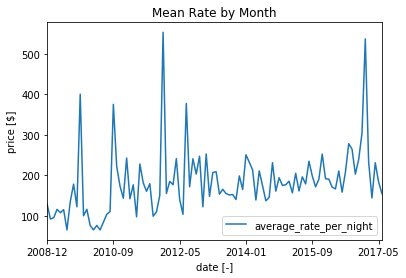

In [4]:
subdata = pd.DataFrame({'date_num'               : data['date_num'].values,
                        'average_rate_per_night' : data['average_rate_per_night'].values})

subdata = subdata.groupby('date_num').agg(np.mean)
subdata.plot()
plt.title('Mean Rate by Month')
plt.xlabel('date [-]')
plt.ylabel('price [$]')
plt.show()

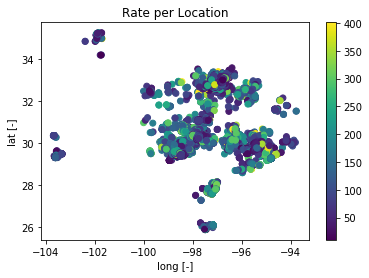

In [8]:
threshhold = data['average_rate_per_night'].quantile(0.90)
mask = data['average_rate_per_night'] < threshhold

plt.scatter(data['longitude'][mask].values, data['latitude'][mask].values, c = data['average_rate_per_night'][mask].values)
plt.colorbar()
plt.title('Rate per Location')
plt.ylabel('lat [-]')
plt.xlabel('long [-]')
plt.show()

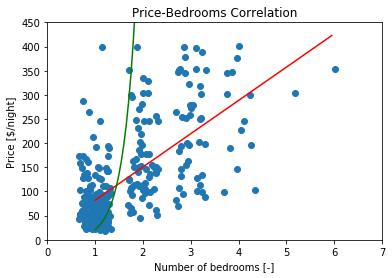

In [16]:
threshhold = data['average_rate_per_night'].quantile(0.90)

def create_sample_mask(size, bias = 0.05):
    sample_mask = np.random.rand(size)   
    return sample_mask < bias

mask = (data['bedrooms_count'] != 'Studio').values & (data['bedrooms_count'] != 'nan').values

sample_mask = create_sample_mask(size = len(mask), bias = 0.02)
mask &= sample_mask
mask &= data['average_rate_per_night'] < threshhold

x = data['bedrooms_count'][mask].map(lambda x: np.int(x)).values
y = data['average_rate_per_night'][mask].values

off1 = (np.random.rand(sum(mask)) / 1.5) - 0.33
off2 = (np.random.rand(sum(mask)) * 10) - 5

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

x_fit = np.arange(1, x.max(), 0.05)
y_lin = slope * x_fit + intercept

p  = np.polyfit(x, np.log(y), 1)
p2 = np.polyfit(x, y,         2)

y_exp = p[0] * np.exp(x_fit * p[1])

plt.scatter(x + off1, y + off2)
plt.plot(x_fit, y_lin, 'r')
plt.plot(x_fit, y_exp, 'g')
plt.xlim([0, x.max() +  1])
plt.ylim([0, y.max() + 50])
plt.xlabel('Number of bedrooms [-]')
plt.ylabel('Price [$/night]')
plt.title('Price-Bedrooms Correlation')
plt.show()

In [59]:
subdata_cities = pd.DataFrame({'city'      : data['city'].values,
                               'longitude' : data['longitude'].values,
                               'latitude'  : data['latitude'].values})

subdata_cities = subdata_cities.groupby('city').agg({'longitude' : np.mean,
                                                     'latitude'  : np.mean})

top_cities = data['city'].value_counts().index[ : 20]

subdata_cities = subdata_cities.loc[top_cities]

In [43]:
def get_wiki_loc(city):
    url = 'https://en.wikipedia.org/wiki/' + city + ',_Texas'
    page = urllib.request.urlopen(url)
    soup = bs4.BeautifulSoup(page, 'html.parser')
    geos = soup.findAll("span", { "class" : "geo" })
    
    coords = geos[0].text.split('; ')
    return (float(coords[0]), float(coords[1]))

In [64]:
lat = []
lon = []
for city in top_cities:    
    coords = get_wiki_loc(city)
    lat.append(coords[0])
    lon.append(coords[1])

lat = np.array(lat)
lon = np.array(lon)

In [69]:
def haversine_func(lat1, lon1, lat2, lon2):
    # by Sofia Heisler; https://github.com/sversh/pycon2017-optimizing-pandas
    
    R = 6378
    
    lat1, lon1, lat2, lon2 = map(np.deg2rad, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1 
    dlon = lon2 - lon1 
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon /2 ) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    
    return c * R

In [75]:
diff = haversine_func(lat, lon, subdata_cities['latitude'].values, subdata_cities['longitude'].values)

subdata_cities.insert(len(subdata_cities.columns), 'lat_wiki', lat, allow_duplicates = False)
subdata_cities.insert(len(subdata_cities.columns), 'lon_wiki', lon, allow_duplicates = False)
subdata_cities.insert(len(subdata_cities.columns), 'diff_km', diff, allow_duplicates = False)

In [76]:
subdata_cities

,latitude,longitude,lat_wiki,lon_wiki,diff_km
Houston,29.740815,-95.354375,29.762780,-95.383060,3.696415
Austin,30.283658,-97.749754,30.267000,-97.733000,2.456170
San Antonio,29.501488,-98.500310,29.417000,-98.500000,9.405029
Dallas,32.846867,-96.789078,32.775830,-96.796670,7.939429
Fort Worth,32.750184,-97.355270,32.757358,-97.333181,2.216780
Corpus Christi,27.664291,-97.278171,27.742780,-97.401940,15.004526
College Station,30.587724,-96.307622,30.601390,-96.314440,1.655566
Irving,32.861969,-96.969434,32.817000,-96.950000,5.325629
Bryan,30.656215,-96.357600,30.665560,-96.366670,1.355118
New Braunfels,29.707424,-98.126694,29.700000,-98.117000,1.249550


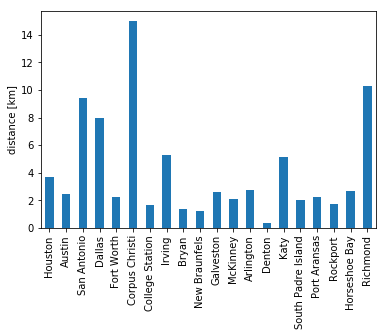

In [79]:
subdata_cities['diff_km'].plot.bar()
plt.ylabel('distance [km]')
plt.show()